## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
fit = sf.data.World.load('data/zshi.sp-102492.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 11860, 'position': 3681, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(1.1444092e-05, dtype=float32)
Frozen(SortedKeysDict({'strain': 198, 'sample': 11860, 'position': 3681, 'allele': 2}))


In [6]:
ref = sf.data.Metagenotypes.load('data/gtprodb.sp-102492.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 3681})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


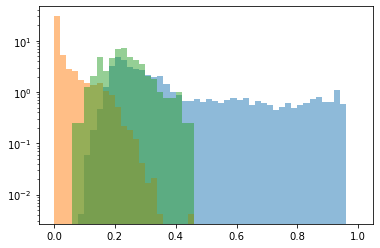

In [7]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-10).entropy(), bins=bins, alpha=0.5, density=True)
plt.hist(fit.metagenotypes.entropy(), bins=bins, alpha=0.5, density=True)
plt.hist(fit.genotypes.entropy(), bins=bins, alpha=0.5, density=True)
# plt.hist(ref.entropy(), bins=bins, alpha=0.5, density=True)

plt.yscale('log')
None

In [8]:
rank_abundance = fit.communities.to_series().groupby(level='sample').apply(lambda x: pd.Series(sorted(x)[::-1])).rename_axis(['sample', 'rank'])
cum_rank_abundance = rank_abundance.unstack('rank').sort_index('columns').cumsum(1).stack()
rev_cum_rank_abundance = rank_abundance.unstack('rank').sort_index('columns', ascending=False).cumsum(1).stack()

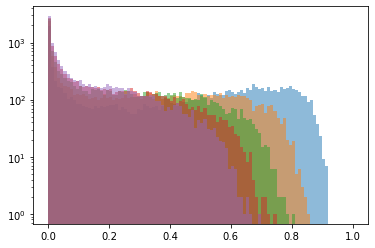

In [9]:
bins = np.linspace(0, 1, num=101)
for rank in range(5):
    plt.hist(rev_cum_rank_abundance.xs(rank + 1, level='rank'), bins=bins, alpha=0.5)
plt.yscale('log')

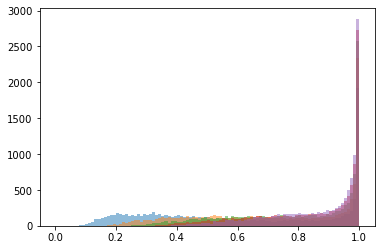

In [10]:
bins = np.linspace(0, 1, num=101)
for rank in range(5):
    plt.hist(cum_rank_abundance.xs(rank, level='rank'), bins=bins, alpha=0.5)

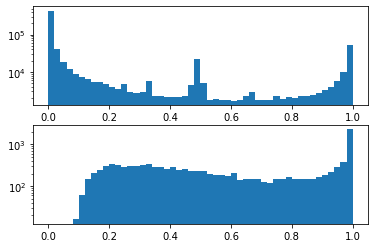

In [11]:
bins = np.linspace(0, 1, num=51)

fig, axs = plt.subplots(2)
axs[0].hist(fit.genotypes.values.flatten(), bins=bins)
axs[1].hist(fit.communities.max("strain").values.flatten(), bins=bins)

for ax in axs:
    pass
    ax.set_yscale('log')
None

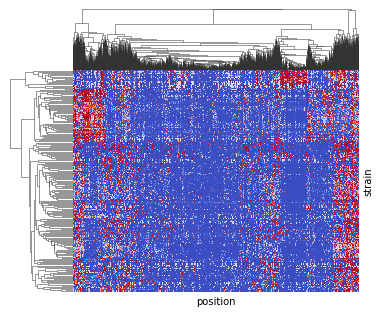

In [12]:
sf.plot.plot_genotype(fit, scaley=2e-2, scalex=1e-3, yticklabels=0)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


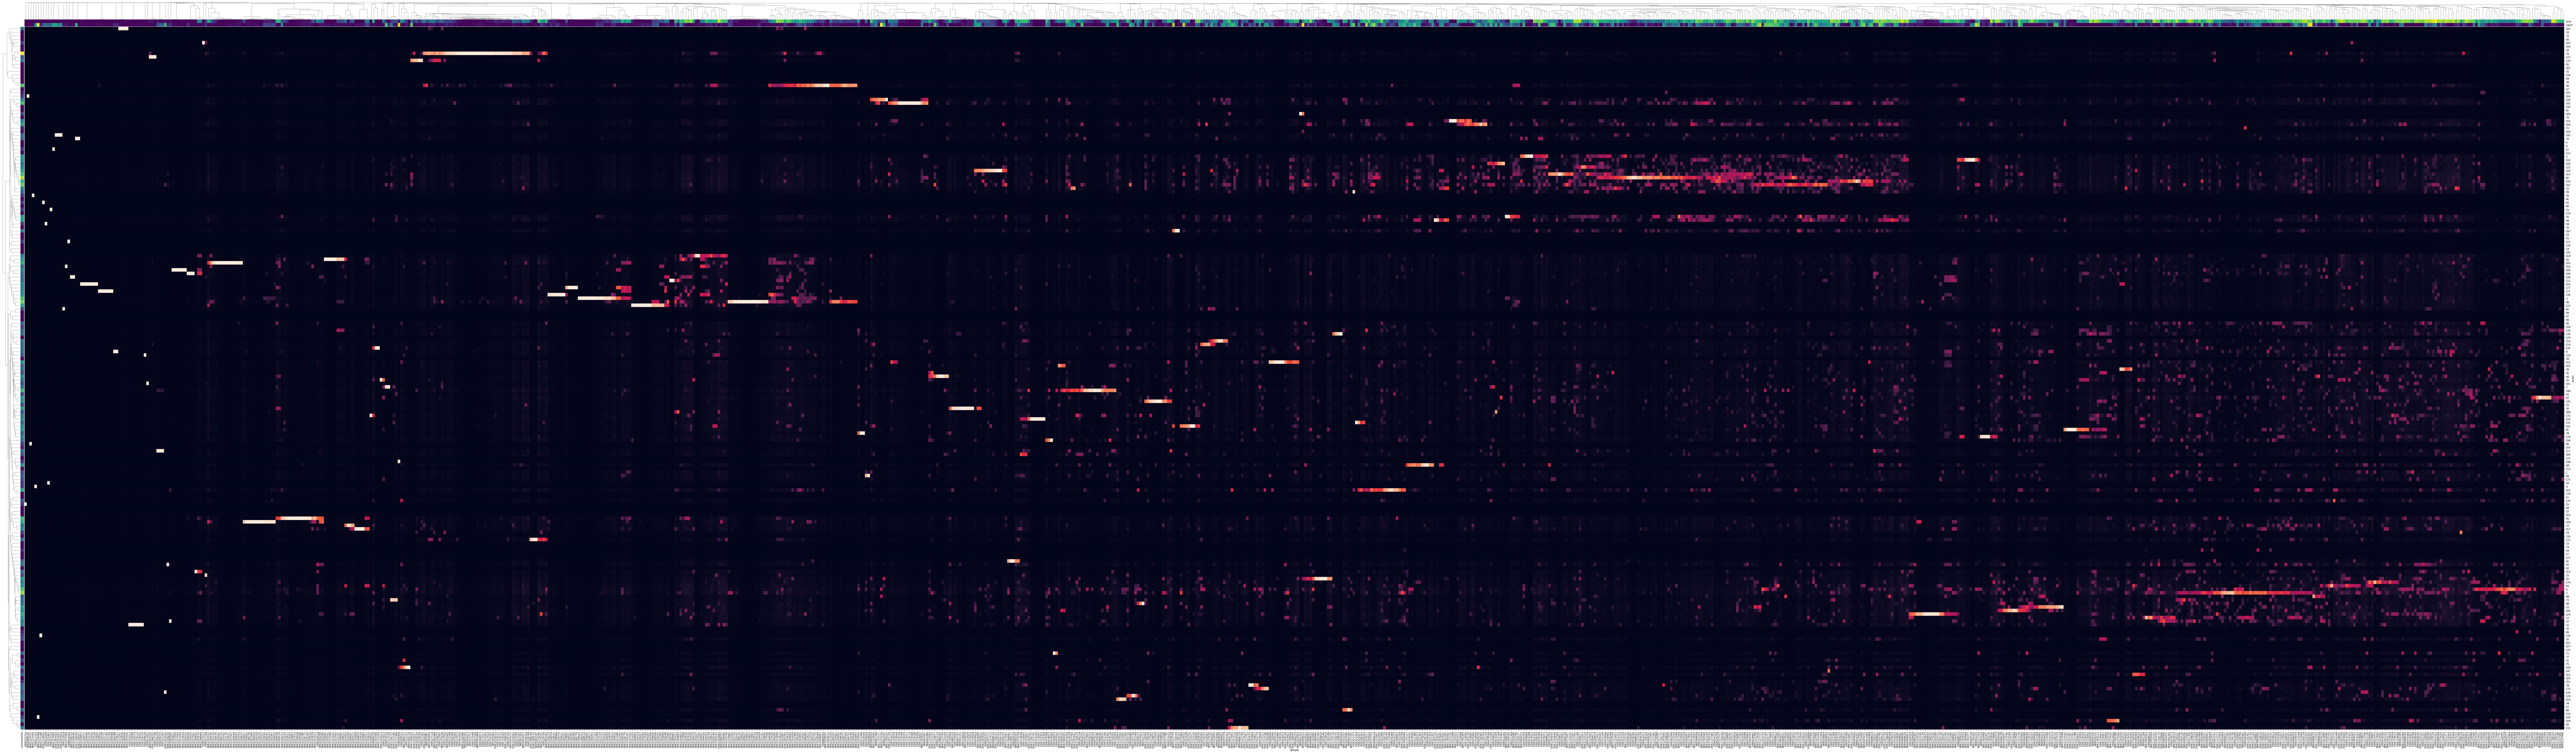

In [13]:
sf.plot.plot_community(
    fit.random_sample(sample=1000),
    col_colors_func=lambda w: xr.Dataset(dict(
        cent=w.communities.entropy("sample"),
        ment=w.metagenotypes.entropy("sample"),
    )),
    row_linkage_func=lambda w: w.genotypes.linkage("strain"),
#     yticklabels=0
)

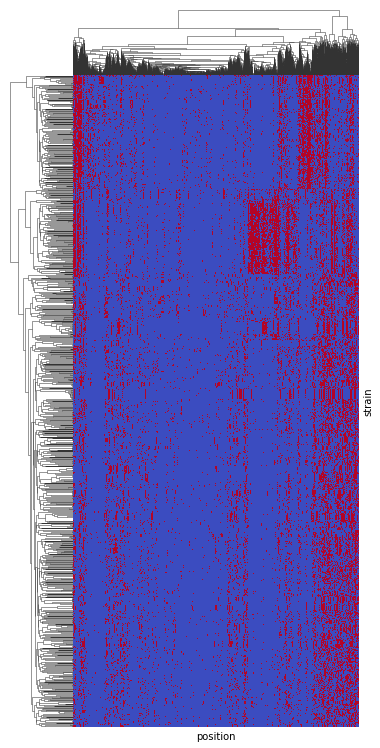

In [14]:
sf.plot.plot_genotype(ref, scaley=1e-2, scalex=1e-3, yticklabels=0)

In [15]:
genotype_entropy_thresh = 0.30

fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < genotype_entropy_thresh)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > genotype_entropy_thresh)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 167, 'position': 3681}),
 Frozen({'strain': 31, 'position': 3681}))

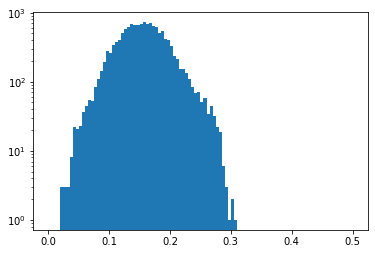

In [16]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

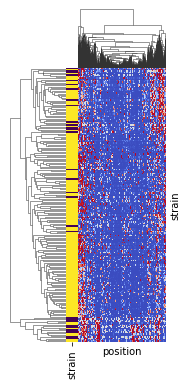

In [17]:
g = sf.data.Genotypes.concat(dict(
    bad=fit_genotypes_highent,
    good=fit_genotypes_filt
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=1000), row_colors_func=lambda w: w.strain.str.startswith('good'), scaley=2e-2, scalex=1e-3, yticklabels=0)

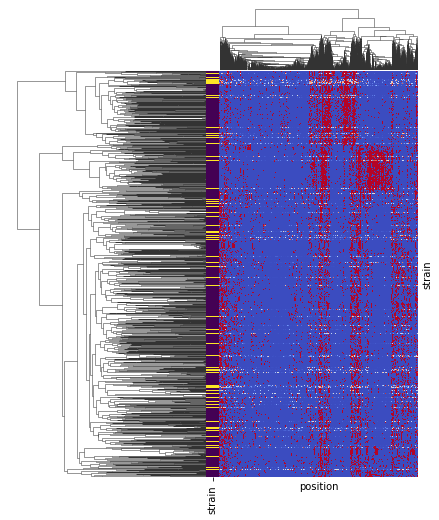

In [18]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(
    g.random_sample(position=2500),
    row_colors_func=lambda w: w.strain.str.startswith('fit'),
    scaley=5e-3,
    scalex=1e-3,
    yticklabels=0,
    dwidth=3.0,
)

In [55]:
from scipy.spatial.distance import pdist, squareform

g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes,
), dim='strain')

_dist = squareform(pdist(g.discretized().values, metric='hamming'))
_dist = pd.DataFrame(_dist, index=g.strain, columns=g.strain)
fit_to_ref_dist = _dist.loc[lambda x: x.index.str.startswith('ref_'), lambda x: x.index.str.startswith('fit_')]

min_fit_to_ref_dist = fit_to_ref_dist.min(axis=0)
min_ref_to_fit_dist = fit_to_ref_dist.min(axis=1)

In [66]:
# Taken from https://gist.github.com/peterk87/b203f62a71d7f4fb273139b219af5e81

from typing import List

def _scipy_tree_to_newick_list(node: sp.cluster.hierarchy.ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: sp.cluster.hierarchy.ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])

In [69]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from io import StringIO
from Bio import Phylo
from copy import deepcopy

tree = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist), method='average')), leaf_names=_dist.columns)), format='newick')

def prune_all_but(tree, names):
    tree = deepcopy(tree)
    all_leaves = tree.get_terminals()
    prune_list = []
    for leaf in all_leaves:
        prune_list += [leaf.name]
    for name in names:
        prune_list.remove(name)
    for name in prune_list:
        tree.prune(name)
    return tree

total_length = tree.total_branch_length()
fit_length = prune_all_but(tree, idxwhere(_dist.index.to_series().str.startswith('fit_'))).total_branch_length()
ref_length = prune_all_but(tree, idxwhere(_dist.index.to_series().str.startswith('ref_'))).total_branch_length()
fit_only = total_length - ref_length
ref_only = total_length - fit_length
shared_length = total_length - (fit_only + ref_only)

print(total_length, fit_length, ref_length, fit_only, ref_only, shared_length, fit_only / total_length, ref_only / total_length, shared_length / total_length)

134.17530565666826 35.90379968410122 110.70447608866846 23.4708295679998 98.27150597256704 12.432970116101416 0.17492659661277504 0.7324112696566317


In [70]:
_dist2 = g.pdist()
tree2 = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist2), method='average')), leaf_names=_dist.columns)), format='newick')
total_length = tree2.total_branch_length()
fit_length = prune_all_but(tree2, idxwhere(_dist2.index.to_series().str.startswith('fit_'))).total_branch_length()
ref_length = prune_all_but(tree2, idxwhere(_dist2.index.to_series().str.startswith('ref_'))).total_branch_length()
fit_only = total_length - ref_length
ref_only = total_length - fit_length
shared_length = total_length - (fit_only + ref_only)

print(total_length, fit_length, ref_length, fit_only, ref_only, shared_length, fit_only / total_length, ref_only / total_length, shared_length / total_length)

121.85466159394552 27.93627761101978 107.07674968124421 14.777911912701313 93.91838398292575 13.158365698318462 0.121274900109653 0.7707410020626752


In [71]:
def all_taxa_names(tree):
    out = []
    for t in tree.get_terminals():
        out.append(t.name)
    return out

In [111]:
def tree_branch_length_fractions(tree, taxaA):
    taxaA = set(taxaA)
    taxaB = set(all_taxa_names(tree)) - taxaA
    total_length = tree.total_branch_length()
    lengthA = prune_all_but(tree, taxaA).total_branch_length()
    lengthB = prune_all_but(tree, taxaB).total_branch_length()
    onlyA = total_length - lengthB
    onlyB = total_length - lengthA
    return pd.Series(dict(total=total_length, onlyA=onlyA, onlyB=onlyB, shared=total_length - (onlyA + onlyB)))

tree_branch_length_fractions(tree2, idxwhere(_dist2.index.to_series().str.startswith('fit_')))

total     121.854662
onlyA      14.777912
onlyB      93.918384
shared     13.158366
dtype: float64

In [112]:
from tqdm import tqdm

def tree_branch_length_fractions_permutation_test(tree, taxa, n=1, progress=False):
    observed = tree_branch_length_fractions(tree, taxa)
    ntaxa = len(taxa)
    perm = []
    for i in tqdm(range(n), disable=(not progress)):
        perm_taxa = np.random.choice(all_taxa_names(tree), ntaxa, replace=False)
        perm.append(tree_branch_length_fractions(tree, perm_taxa))
    return observed, pd.DataFrame(perm)
    
observed, perm = tree_branch_length_fractions_permutation_test(tree, idxwhere(_dist.index.to_series().str.startswith('fit_')), n=10, progress=True)

100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


In [113]:
observed, perm

(total     134.175306
 onlyA      23.470830
 onlyB      98.271506
 shared     12.432970
 dtype: float64,
         total      onlyA       onlyB     shared
 0  134.175306  17.623542  102.675925  13.875838
 1  134.175306  16.580756  103.068323  14.526227
 2  134.175306  17.762622  103.152167  13.260517
 3  134.175306  17.090324  102.372288  14.712693
 4  134.175306  17.377549  102.568601  14.229156
 5  134.175306  17.271000  103.226287  13.678019
 6  134.175306  15.727861  104.401045  14.046400
 7  134.175306  16.623429  102.777213  14.774663
 8  134.175306  17.158505  102.906691  14.110110
 9  134.175306  16.453611  103.400571  14.321124)

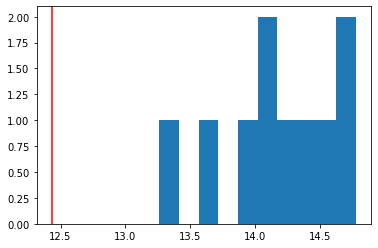

In [116]:
plt.hist(perm['shared'])
plt.axvline(observed['shared'], color='r')

In [132]:
clust_thresh = 0.05

ref_dist = _dist.loc[_dist.columns.str.startswith('ref_'), _dist.columns.str.startswith('ref_')].rename(index=lambda s: s[4:]).rename(columns=lambda s: s[4:])
fit_dist = _dist.loc[_dist.columns.str.startswith('fit_'), _dist.columns.str.startswith('fit_')].rename(index=lambda s: s[4:]).rename(columns=lambda s: s[4:])
ref_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(ref_dist),
    index=ref_dist.columns,
)
fit_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

ref_clust.value_counts()

19     15
10      7
14      7
42      6
38      6
       ..
352     1
353     1
354     1
355     1
752     1
Length: 753, dtype: int64

In [133]:
fit_clust.value_counts().sort_values(ascending=False).head()

0     1
24    1
23    1
2     1
3     1
dtype: int64

In [134]:
ref_dedup = sf.Genotypes(ref.to_series().unstack('strain').groupby(ref_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())
fit_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

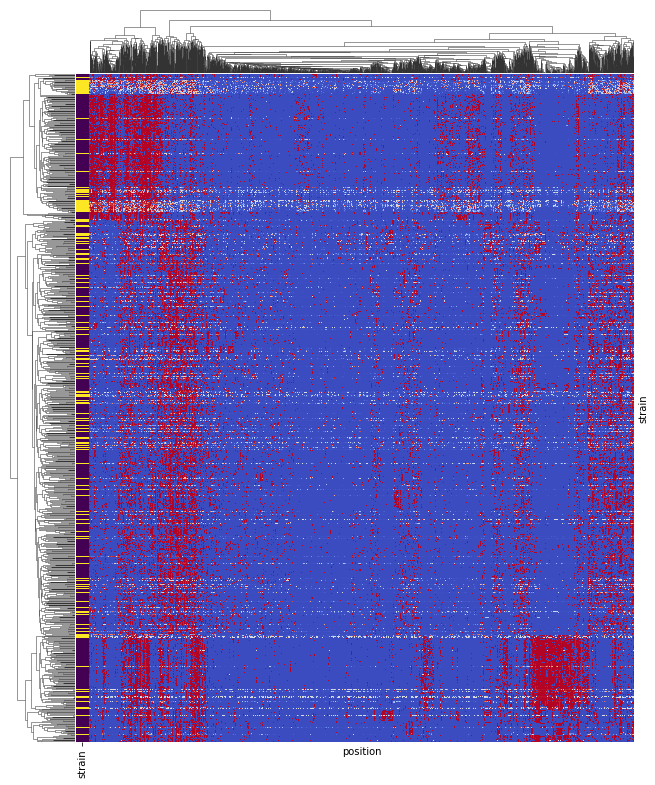

In [135]:
g = sf.data.Genotypes.concat(dict(
    ref=ref_dedup,
    fit=fit_dedup,
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=2500), row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=1e-2, scalex=3e-3, yticklabels=0)

In [196]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes,
), dim='strain')

all_dist = g.discretized().pdist()

In [200]:
all_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=0.15, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(all_dist),
    index=g.strain,
)

clust_stats = (
    all_clust
    .to_frame(name='clust')
    .reset_index()
    .assign(prefix=lambda x: x.strain.str[:3])
    .groupby(['clust', 'prefix'])
    .apply(len)
    .unstack(fill_value=0)
    .assign(
        tally=lambda x: x.sum(1),
        ratio=lambda x: np.log2((x.fit + 1) / (x.ref + 1))
    )
    .assign(only_fit=lambda x: x.ref==0, only_ref=lambda x: x.fit==0)
    .assign(both=lambda x: ~(x.only_fit | x.only_ref))
    .sort_values('ratio', ascending=False)
)

In [201]:
geno_clust = sf.Genotypes(g.to_series().unstack('strain').groupby(all_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())

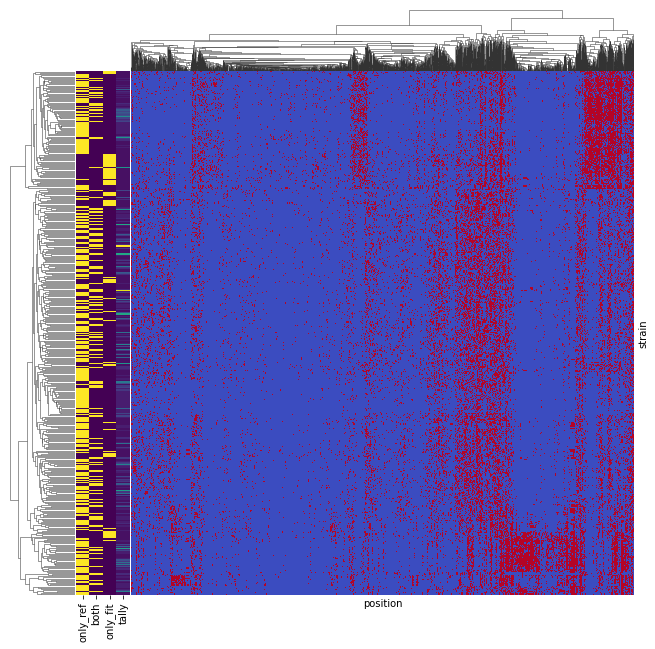

In [203]:
sf.plot.plot_genotype(geno_clust.discretized().random_sample(position=2500), row_colors_func=lambda w: clust_stats[['only_ref', 'both', 'only_fit', 'tally']].to_xarray(), scaley=1e-2, scalex=3e-3, yticklabels=0)

In [136]:
from scipy.spatial.distance import pdist, squareform

_dist3 = pd.DataFrame(squareform(pdist(g.discretized().values, metric='hamming')), index=g.strain, columns=g.strain)
_tree3 = Phylo.read(StringIO(to_newick(to_tree(linkage(squareform(_dist3), method='average')), leaf_names=_dist3.columns)), format='newick')

observed, perm = tree_branch_length_fractions_permutation_test(_tree3, idxwhere(_dist3.index.to_series().str.startswith('fit_')), n=10, progress=True)

print(observed)
perm

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

total     132.265755
onlyA      23.376063
onlyB      96.318584
shared     12.571108
dtype: float64


,total,onlyA,onlyB,shared
0,132.265755,24.086642,99.204744,8.974369
1,132.265755,24.102962,99.751768,8.411025
2,132.265755,24.605144,99.190829,8.469782
3,132.265755,24.915827,99.692867,7.657062
4,132.265755,23.765616,99.727931,8.772209
5,132.265755,25.725751,98.298762,8.241242
6,132.265755,24.035755,99.886947,8.343053
7,132.265755,24.021129,99.719547,8.525079
8,132.265755,24.863414,99.368064,8.034277
9,132.265755,25.516878,98.948733,7.800144


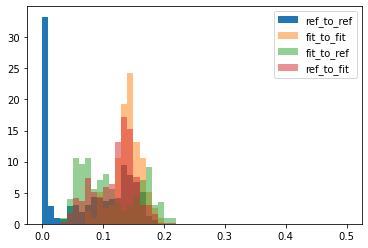

In [56]:
ref_to_ref_dist = _dist.loc[lambda x: x.index.str.startswith('ref_'), lambda x: x.index.str.startswith('ref_')]
fit_to_fit_dist = _dist.loc[lambda x: x.index.str.startswith('fit_'), lambda x: x.index.str.startswith('fit_')]

min_ref_to_ref_dist = (ref_to_ref_dist + np.eye(ref_to_ref_dist.shape[0])).min(0)
min_fit_to_fit_dist = (fit_to_fit_dist + np.eye(fit_to_fit_dist.shape[0])).min(0)

plt.hist(min_ref_to_ref_dist, bins=bins, alpha=1.0, density=True, label='ref_to_ref')
plt.hist(min_fit_to_fit_dist, bins=bins, alpha=0.5, density=True, label='fit_to_fit')
plt.hist(min_fit_to_ref_dist, bins=bins, alpha=0.5, density=True, label='fit_to_ref')
plt.hist(min_ref_to_fit_dist, bins=bins, alpha=0.5, density=True, label='ref_to_fit')
plt.legend()

In [57]:
min_ref_to_ref_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.000000
0.01    0.000000
0.05    0.000000
0.10    0.000000
0.25    0.001358
0.50    0.083537
0.75    0.136987
0.90    0.154876
0.95    0.162741
0.99    0.175797
1.00    0.189351
dtype: float64

In [58]:
min_fit_to_fit_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.076610
0.01    0.078191
0.05    0.095124
0.10    0.107036
0.25    0.131011
0.50    0.142488
0.75    0.155325
0.90    0.166286
0.95    0.178253
0.99    0.189688
1.00    0.198587
dtype: float64

In [59]:
min_fit_to_ref_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.039120
0.01    0.044662
0.05    0.050407
0.10    0.054442
0.25    0.069750
0.50    0.102418
0.75    0.159468
0.90    0.179190
0.95    0.190329
0.99    0.204768
1.00    0.213257
dtype: float64

In [60]:
min_ref_to_fit_dist.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

0.00    0.039120
0.01    0.047805
0.05    0.057036
0.10    0.071176
0.25    0.097120
0.50    0.128769
0.75    0.143507
0.90    0.155936
0.95    0.168528
0.99    0.183116
1.00    0.211627
dtype: float64

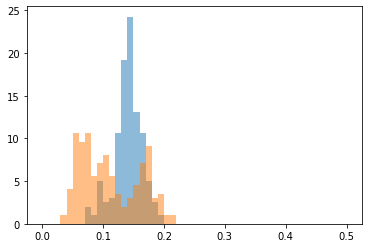

In [62]:
bins = np.linspace(0, 0.5, num=51)
plt.hist(min_fit_to_fit_dist, bins=bins, alpha=0.5, density=True)
plt.hist(min_fit_to_ref_dist, bins=bins, alpha=0.5, density=True)
# plt.hist(_dist.unstack(), bins=bins, alpha=0.5, density=True)

None

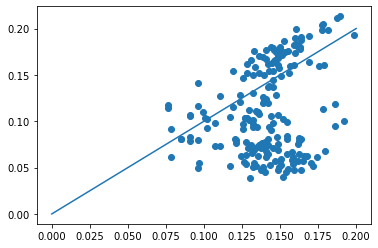

In [63]:
plt.scatter(min_fit_to_fit_dist, min_fit_to_ref_dist)
plt.plot([0, 0.2], [0, 0.2])

In [64]:
strain_coverage = (fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample").to_series().rename(lambda s: f'fit_{s}')
strain_entropy = g.entropy().to_series()

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


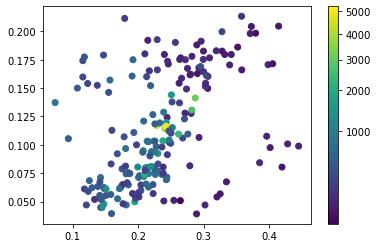

In [65]:
plt.scatter('entropy', 'min_dist', c='coverage', data=min_fit_to_ref_dist.to_frame(name='min_dist').join(strain_entropy).assign(coverage=strain_coverage), norm=mpl.colors.PowerNorm(1/2))
plt.colorbar()

In [19]:
sample_meta = pd.read_table('raw/shi2019s13.tsv').set_index('NCBI Accession Number')

sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len)

Continent  Country  Study                
AF         MDG      CM_madagascar            112
           TZA      RampelliS_2015            27
                    SmitsSA_2017              40
AS         BGD      DavidLA_2015              35
           BRN      ChngKR_2016                2
           CHN      ChengpingW_2017           96
                    ChngKR_2016               20
                    HeQ_2017                 118
                    LiJ_2014                   7
                    LiJ_2017                 196
                    QinJ_2012                199
                    QinN_2014                233
                    WenC_2017                168
                    YuJ_2015                 128
           IDN      ChngKR_2016                2
           ISR      ZeeviD_2015              954
           KAZ      CosteaPI_2017            164
           MNG      LiuW_2016                110
           MYS      ChngKR_2016                8
           SGP      ChngKR_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


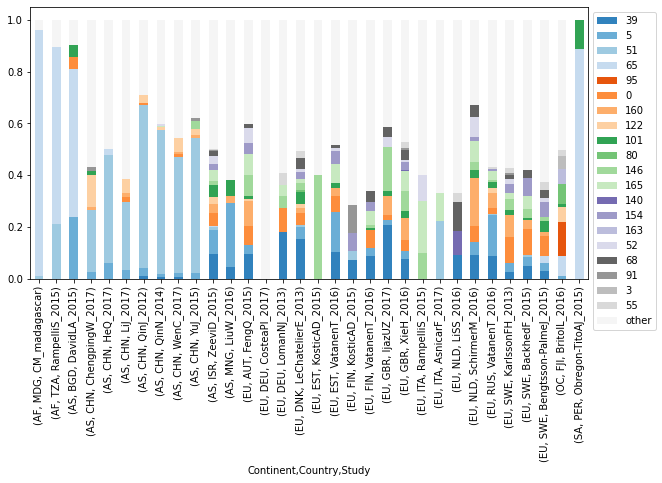

In [20]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

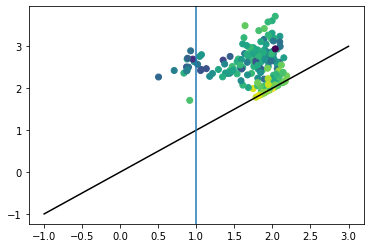

In [21]:
d = pd.DataFrame(dict(
    total=(fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample"),
    maximum=(fit.communities.data * fit.metagenotypes.mean_depth()).max("sample"),
    entropy=fit.genotypes.entropy(),
), index=fit.strain)

plt.scatter('maximum', 'total', data=np.log10(d), c='entropy')
plt.plot([-1, 3], [-1, 3], color='k')
plt.axvline(1)

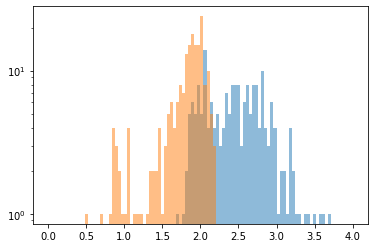

In [22]:
plt.hist((fit.communities.data * fit.metagenotypes.mean_depth()).sum("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101), alpha=0.5)
plt.hist((fit.communities.data * fit.metagenotypes.mean_depth()).max("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101), alpha=0.5)

plt.yscale('log')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


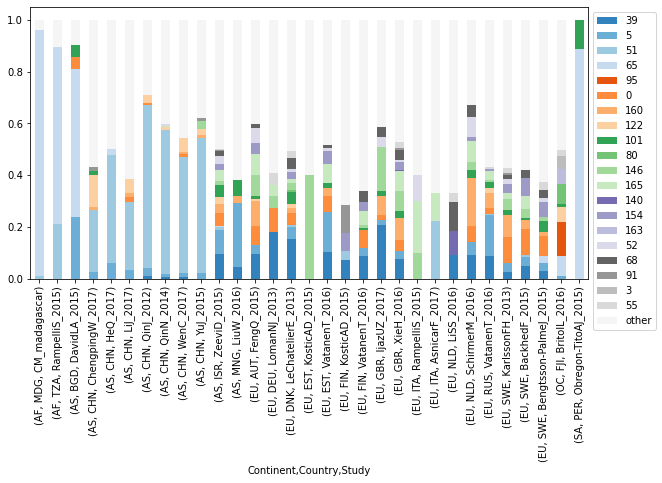

In [23]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


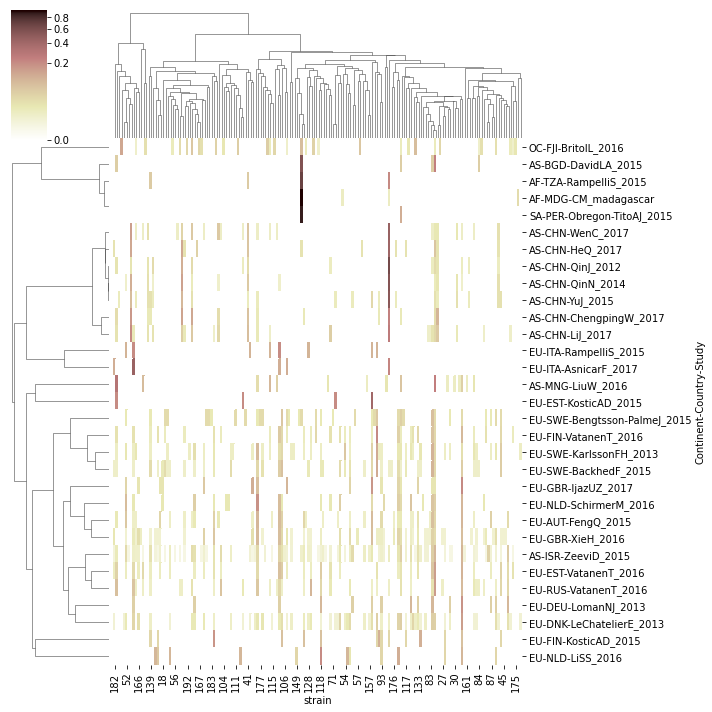

In [24]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(50).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
#     .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
    .reindex(fit.strain, axis='columns')
    .fillna(0)
)

d2 = d1.loc[d1.max(1) > 0, d1.max(0) > 0]


sns.clustermap(
    d2,
    norm=mpl.colors.PowerNorm(1/3),
    col_linkage=fit.genotypes.mlift('sel', strain=d2.columns).linkage(),
    metric='cosine',
    cmap='pink_r',
)

In [25]:
clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=0.15, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(fit.genotypes.pdist()),
    index=fit.strain,
)


agg_communities = fit.communities.to_series().unstack().groupby(clust, axis='columns').sum()

clust.value_counts()

7     25
8     20
14    18
22    11
10     9
      ..
39     1
41     1
42     1
43     1
65     1
Length: 66, dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


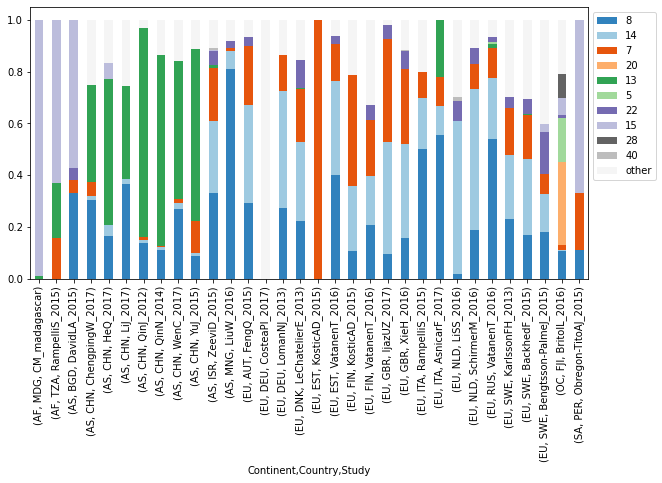

In [26]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(10).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


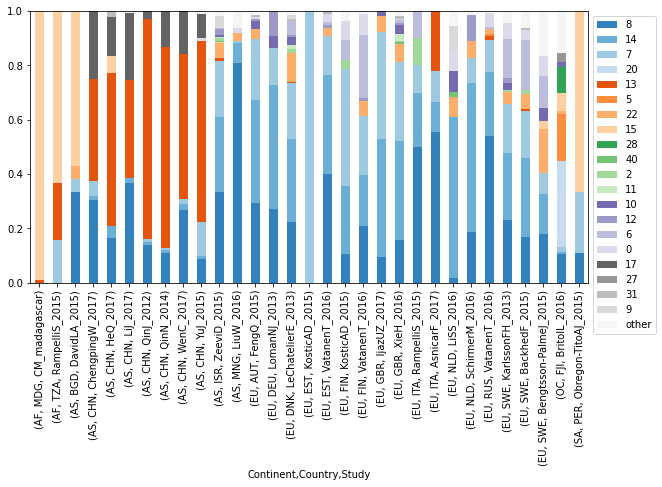

In [27]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


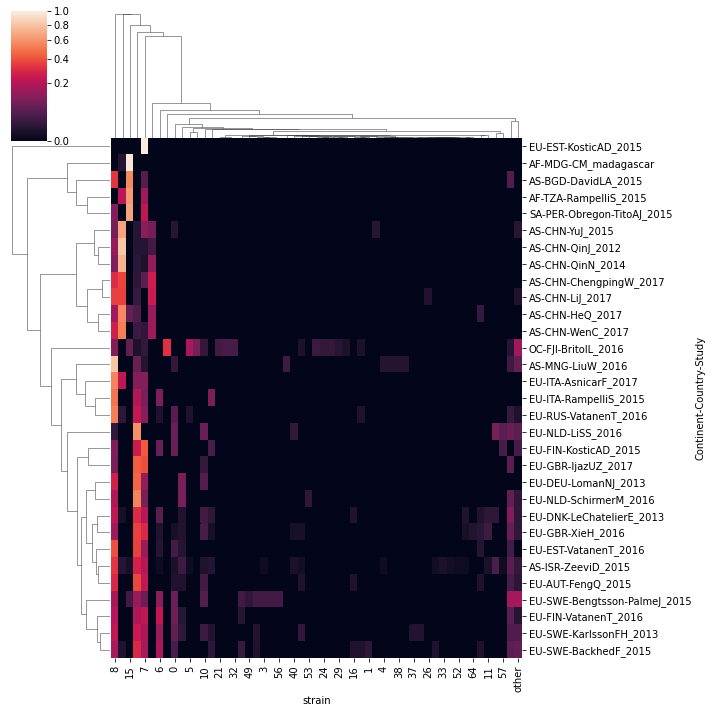

In [28]:
dominant_strain = agg_communities.idxmax(1)
# top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


sns.clustermap(d1, norm=mpl.colors.PowerNorm(1/2))